# TIRL demo - mapping microscopy to MRI

In this script we demonstrate how you can map microscopy images through to MRI space using tirl outputs.

We output the microscopy section mapped into the MRI volume (nifti file), and demo some simple correlation plots.


In [3]:
### Must first activate tirl env if not using FSL version

# Imports
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tirl
from tirl.timage import TImage
! tirl version

3.3.0


## Load and visualise the microscopy and MRI

/home/fs0/amyh/.conda/envs/tirlenv_v3.2/lib/python3.8/site-packages/tirl-3.3.0-py3.8-linux-x86_64.egg/tirl/tfield.py:882: UserWarning: Auto-detected tensor axes: (2,)
  warnings.warn("Auto-detected tensor axes: {}".format(t_axes))


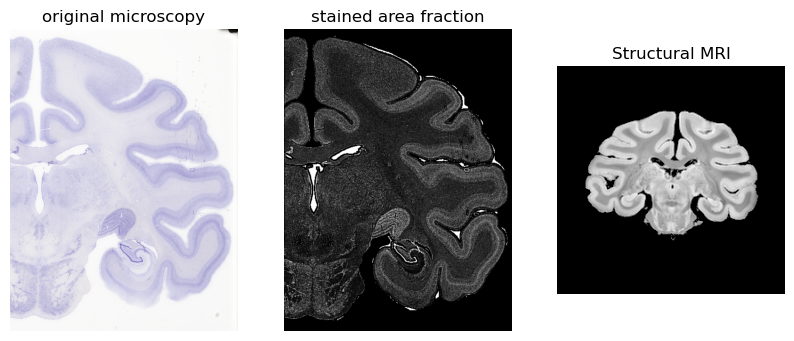

In [74]:
# Here I have first ran code to compute stained area fraction map from SVS file
####!~/run_SAF.m not run due to time constraints

# Load the microscopy images
microscopy_rgb = TImage('demo_files/CV090a_thumb.tif')  # reference
microscopy_rgb.normalise()
microscopy = TImage('demo_files/CV090a_SAF_moderate.tif')   # image I want to map to MRI
microscopy.normalise()

# Display the image using matplotlib
plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.imshow(microscopy_rgb.data)
plt.axis('off') 
plt.title('original microscopy')
plt.subplot(132)
plt.imshow(microscopy_saf.data, cmap='gray')
plt.axis('off')  
plt.title('stained area fraction')

# Also show MRI we want to register to (approx slice shown before registration)
struct = TImage('demo_files/struct_brain.nii.gz')
plt.subplot(133)
plt.imshow(np.squeeze(struct.data[:,110,:].T[::-1,:]), cmap='gray')
plt.axis('off')  
plt.title('Structural MRI')

plt.show()

## Run TIRL registration

Note in BigMac, the tirl registration has been run for you and you can skip this step. Here we show how the registration was run as an example for others who may be working with different data.

### First write config file

In [ ]:
# First write config file
!more demo_files/configuration.json

# We recommend you start with a config file from an existing project
# Main things that then need changing are the input/output file/directory names, 
# the micrscopy resolution, and the slice 'centre', which is an approx initial position for the microscopy
# in the MRI volume (in real not voxel space)

{
    "general": {
        "cost": "MIND",
        "isotropic": true,
        "logfile": "/vols/Data/BigMac/Microscopy/Cresyl/Anterior/CV090x/structur
eTensor/CV090a_ST_150/Reg2MRI/logfile.log",
        "loglevel": 10,
        "name": "bigmac_xy",
        "outputdir": "/vols/Data/BigMac/Microscopy/Cresyl/Anterior/CV090x/struct
ureTensor/CV090a_ST_150/Reg2MRI/",
        "paramlogfile": "/vols/Data/BigMac/Microscopy/Cresyl/Anterior/CV090x/str
uctureTensor/CV090a_ST_150/Reg2MRI/paramlogfile.log",
        "stages": [
            1,
            2,
            4
        ],
        "system": "linux",
        "verbose": false,
        "warnings": false
    },
    "header": {
        "author": "Istvan N Huszar, Amy FD Howard",
--More--(9%)

### TIRL command

In [35]:
# Here we use the slice_to_volume TIRL script
! tirl slice_to_volume --config ./configuration.json

### Output files

In [27]:
# Visualise output files
!ls tirl-output

# Here we see the MRI 'volume.timg' and the registered microscopy slices output from each of the 
# three registration stages (1_stage1.timg, 2_stage2.timg 3_stage4.timg). We can pick whichever output
# we think is best. Below I use 2_stage which includes linear but not non-linear transformations.

1_stage1.png		 3_stage4.timg
1_stage1_targetmask.png  configuration.json
1_stage1.timg		 control_points_20210303_150810_400932.png
2_stage2.png		 control_points_20210303_150810_400932.txt
2_stage2_targetmask.png  CV090a_thumb_mrires.tif
2_stage2.timg		 logfile.log
3_stage4.png		 paramlogfile.log
3_stage4_targetmask.png  volume.timg


## Map microscopy to MRI using tirl warpfields

### Load tirl outputs


In [28]:
# Load microscopy warpfield and add to the SAF image we want to map
warp = tirl.load('demo_files/tirl-output/2_stage2.timg')
# Copy the warpfield to the microscopy domain
microscopy.domain.copy_transformations(warp.domain)

# Load MRI warpfield 
mri = tirl.load('demo_files/tirl-output/volume.timg')

/home/fs0/amyh/.conda/envs/tirlenv_v3.2/lib/python3.8/site-packages/tirl-3.3.0-py3.8-linux-x86_64.egg/tirl/tirlfile.py:421: UserWarning: Data array is read-only.
  warnings.warn("Data array is read-only.")
/home/fs0/amyh/.conda/envs/tirlenv_v3.2/lib/python3.8/site-packages/tirl-3.3.0-py3.8-linux-x86_64.egg/tirl/tirlfile.py:440: UserWarning: Data array is read-only.
  warnings.warn("Data array is read-only.")


### Map microscopy coordinates to MRI space

In [29]:
# Get the microscopy pixels in physical or real space
pc = microscopy.domain.get_physical_coordinates() # cordinates in physical space 

# Map these through the MRI domain to voxel space
vc = np.round(mri.domain.map_physical_coordinates(pc)).astype(int) # coordinates in structural space

# Clip output to ensure that we are not trying to index voxels outside the structural volume
vc = np.clip(vc, 0, np.subtract(mri.shape, 1)) 


### Calculate mean SAF in those voxels that intersect with the MRI

In [30]:
# Find voxels where the microscopy intersects with the MRI
uni,ind = np.unique(vc,axis=0,return_inverse=True)

# Loop over voxels and take mean value of microscopy pixels per voxel
d = np.zeros(uni.shape[0])
for i in np.arange(uni.shape[0]):
    # Can replace this with median, sum etc
    d[i] = np.mean(microscopy.data.ravel()[ind==i])
    
# Create 3D object of zeros, same size as the MRI    
microscopy_in_mri = np.zeros(mri.shape)

# Fill relevant voxels with microscopy SAF
microscopy_in_mri[tuple(uni.T)] = d

### Save output as nifti

In [33]:
# Copy header from structural MRI volume
newobj = nib.nifti1.Nifti1Image(microscopy_in_mri, None, header=mri.header['meta'])
nib.save(newobj, "demo_files/tirl-output/microscopy_in_mri.nii.gz") 
print("Done")


Done


In [93]:
# Visualise using FSLeyes
! fsleyes struct_brain.nii.gz tirl-output/microscopy_in_mri.nii.gz

^C


## Plot correlation of MRI and microcopy

Now that we have the MRI and microscopy in the same space, it is trivial to run voxel-wise correlations.
Below we correlate this microscopy with structural MRI, as well as diffusion MRI metrics that have been 
previoiusly registered to the structral MRI (i.e. they are in the same space). Altnertaively, the microscopy
can be directly mapped to the dMRI (or another MRI modality) by adding the structural MRI -> other MRI
warpfield to the transformation chain above.

### Correlating the microscopy with the structural MRI

Here we show both a voxelwise scatter plot and density plot

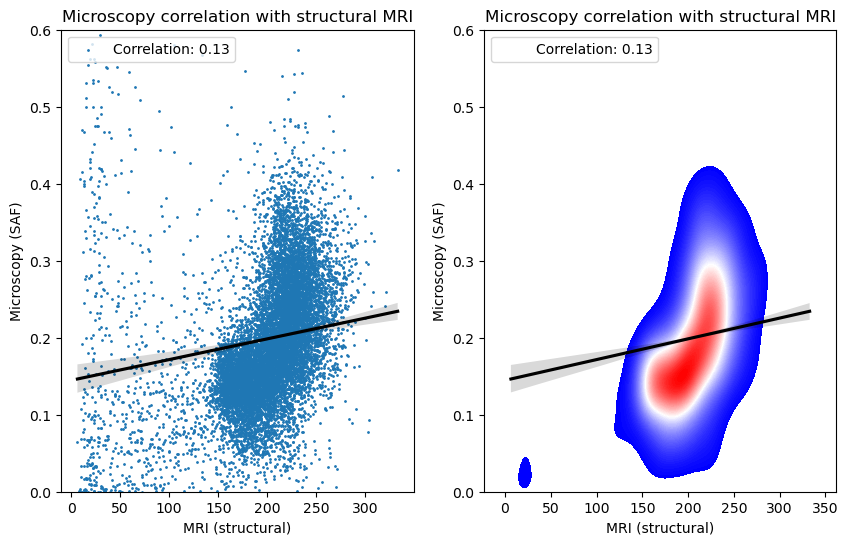

In [98]:
# Specify x,y data in mask
mask = microscopy_in_mri>0
x = mri.data[mask==1]
y = microscopy_in_mri[mask==1]

# Plot
plt.figure(figsize=(10, 6))

#### Scatter plot
plt.subplot(121)
plt.scatter(x,y,s=1)

# Add titles and labels
plt.title('Microscopy correlation with structural MRI')
plt.xlabel('MRI (structural)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')

#### Density plot
plt.subplot(122)
sns.kdeplot(x=x, y=y, cmap='bwr', fill=True, thresh=1e-1, levels=100)

# Add titles and labels
plt.title('Microscopy correlation with structural MRI')
plt.xlabel('MRI (structural)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')

# Show the plot
plt.show()

### Correlating with DTI metrics

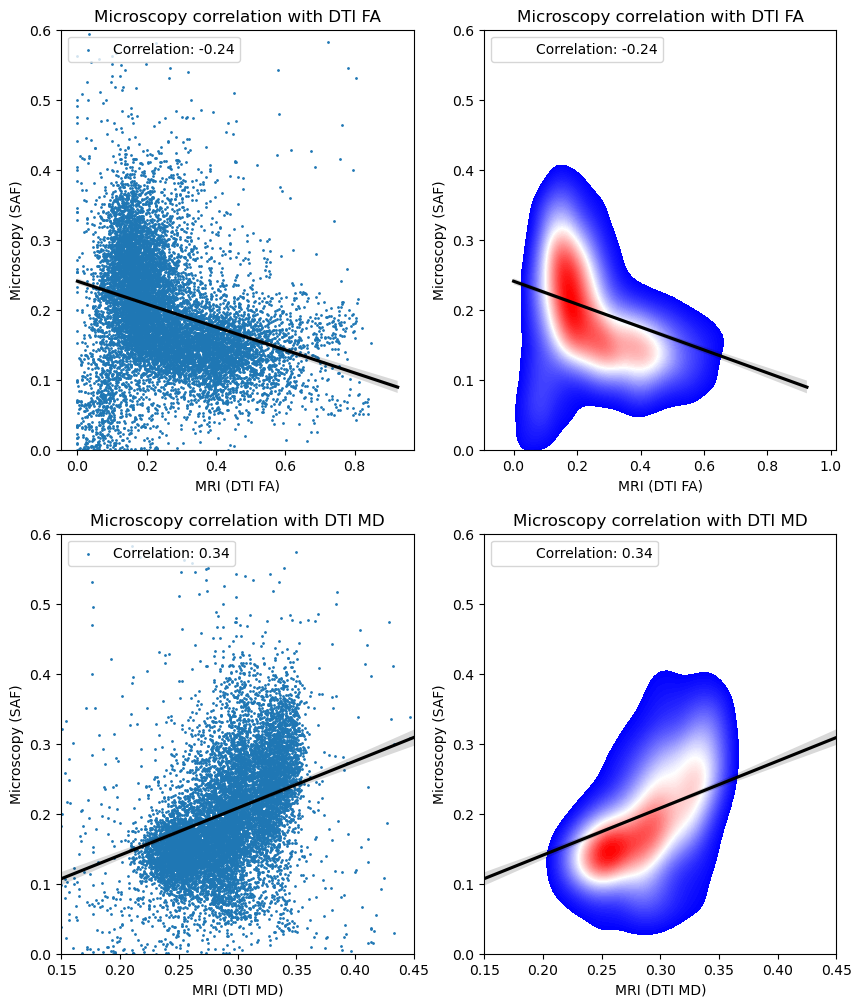

In [99]:
# Specify x,y data  ### FA
FA = TImage('demo_files/dti_FA.nii.gz')
x = FA.data[mask==1]

# Plot
plt.figure(figsize=(10, 12))
plt.subplot(221)
plt.scatter(x,y,s=1)

# Add titles and labels
plt.title('Microscopy correlation with DTI FA')
plt.xlabel('MRI (DTI FA)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')

plt.subplot(222)
sns.kdeplot(x=x, y=y, cmap='bwr', fill=True, thresh=1e-1, levels=100)

# Add titles and labels
plt.title('Microscopy correlation with DTI FA')
plt.xlabel('MRI (DTI FA)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')


#########

# Specify x,y data  ### MD
MD = TImage('demo_files/dti_MD.nii.gz')
x = MD.data[mask==1]*1000

# Plot
plt.subplot(223)
plt.scatter(x,y,s=1)

# Add titles and labels
plt.title('Microscopy correlation with DTI MD')
plt.xlabel('MRI (DTI MD)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)
plt.xlim(0.15,0.45)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')

# Plot
plt.subplot(224)
sns.kdeplot(x=x, y=y, cmap='bwr', fill=True, thresh=1e-1, levels=100)

# Add titles and labels
plt.title('Microscopy correlation with DTI MD')
plt.xlabel('MRI (DTI MD)')
plt.ylabel('Microscopy (SAF)')
plt.ylim(0,0.6)
plt.xlim(0.15,0.45)

# Add a line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Add the correlation coefficient to the legend
corr = np.corrcoef(x, y)[0,1]
plt.legend([f'Correlation: {corr:.2f}'], loc='upper left')


#########

# Show the plot
plt.show()